# Hydrological Modeling

## Introduction

In this tutorial, we use HySetter to obtain the required input data for running the HYdrological MODel [(HYMOD)](https://piahs.copernicus.org/articles/368/180/2015/piahs-368-180-2015.pdf) in two watersheds in the US. HYMOD is a parsimonious conceptual rainfall-runoff model that operates on a daily time step. It is based on the theory of runoff yield under excess infiltration and employs a probability-distributed principle to describe the spatial variability of water storage capacity within a basin. 

The model structure incorporates components for runoff generation and routing, dividing runoff into quick flow (routed through three identical quick flow tanks) and slow flow (routed through a parallel slow flow tank) based on model parameters. The figure below illustrates the flowchart of HYMOD:

<img src="https://raw.githubusercontent.com/hyriver/hysetter/main/docs/examples/images/hymod-flowchart.png" alt="HYMOD Flowchart" style="width: 500px;"/>

The model parameters and their ranges are presented in the following table:

| Parameter | Description | Range |
| --- | --- | --- |
| $C_\mathrm{max}$ | Maximum storage capacity | 1-1500 [mm] |
| $B_\mathrm{exp}$ | Degree of spatial variability of the soil moisture capacity | 0-2 [-] |
| $\alpha$ | Factor for dividing flow into slow and quick releases | 0-1 [-] |
| $K_s$ | Residence time of the slow release reservoir | 0-0.14 [day $^{-1}$] |
| $K_q$ | Residence time of the three quick release reservoirs | 0.14-1 [day $^{-1}$] |

## Model Implementation

First, let's implement the model using `numpy` and `numba`.

In [1]:
import numpy as np
from numba import njit
import numpy.typing as npt

FloatArray = npt.NDArray[np.float32]

@njit(nogil=True)
def _linear_reservoir(
    x_slow: np.float32, inflow: np.float32, k_s: np.float32
) -> tuple[np.float32, np.float32]:
    """Run the linear reservoir model."""
    xn_slow = (1 - k_s) * x_slow + (1 - k_s) * inflow
    outflow = k_s / (1 - k_s) * xn_slow
    return xn_slow, outflow

@njit(nogil=True)
def _excess(
    prcp_t: np.float32,
    pet_t: np.float32,
    x_loss: np.float32,
    c_max: np.float32,
    b_exp: np.float32,
) -> tuple[np.float32, np.float32]:
    """Calculate excess precipitation and evaporation."""
    ct_prev = c_max * (1 - np.power(np.abs(1 - ((b_exp + 1) * (x_loss) / c_max)), 1 / (b_exp + 1)))
    er_1 = np.maximum(prcp_t - c_max + ct_prev, 0)
    s_1 = prcp_t - er_1
    dummy = np.minimum((ct_prev + s_1) / c_max, 1)
    xn = c_max / (b_exp + 1) * (1 - np.power(np.abs(1 - dummy), b_exp + 1))

    er_2 = np.maximum(s_1 - (xn - x_loss), 0.2)

    evap = (1 - (((c_max / (b_exp + 1)) - xn) / (c_max / (b_exp + 1)))) * pet_t
    xn = np.maximum(xn - evap, 0)

    return er_1 + er_2, xn

@njit(nogil=True)
def run_hymod(
    prcp: FloatArray,
    pet: FloatArray,
    c_max: np.float32,
    b_exp: np.float32,
    alpha: np.float32,
    k_s: np.float32,
    k_q: np.float32,
) -> FloatArray:
    """Run HYMOD model."""
    x_loss = np.float32(0.0)
    x_slow = np.float32(0.0)
    outflow = np.float32(0.0)
    x_quick = np.zeros(3, dtype="f4")
    n_steps = prcp.shape[0]
    q_out = np.zeros(n_steps, dtype="f4")

    for t in range(n_steps):
        et, x_loss = _excess(prcp[t], pet[t], x_loss, c_max, b_exp)
        u_q = alpha * et
        u_s = (1 - alpha) * et
        x_slow, q_s = _linear_reservoir(x_slow, u_s, k_s)
        inflow = u_q
        for i in range(3):
            x_quick[i], outflow = _linear_reservoir(x_quick[i], inflow, k_q)
            inflow = outflow
        q_out[t] = q_s + outflow
    return q_out

## Data Preparation

For calibrating the model parameters, we use the `differential_evolution` optimization algorithm from `scipy`. We use the observed streamflow data for calibration with Nash-Sutcliffe Efficiency (NSE) as the objective function.

Among the five parameters, we can estimate $C_\mathrm{max}$ a priori using soil data instead of calibrating it. We use the [SoilGrids](https://soilgrids.org/) dataset to obtain the required soil data. The SoilGrids dataset provides global predictions for standard numeric soil properties (organic carbon, bulk density, cation-exchange capacity, pH, soil texture fractions, etc.) at seven standard depths (0, 5, 15, 30, 60, 100 and 200 cm) at a spatial resolution of 250 m.

To run the model, we require the following data:
1. Upstream drainage area of the target watersheds
2. Forcing data (precipitation and potential evapotranspiration, PET)
3. Soil data (porosity and thickness)
4. Daily streamflow observations at the watersheds' outlets

Note that Daymet does not provide PET, so we either have to use another source, i.e., NLDAS2 (hourly) or GridMET (daily), or compute PET using [PyDaymet](https://docs.hyriver.io/readme/pydaymet.html) package after getting the required data. For example, if we want to use Hargreaves-Samani method to compute PET, we need to get minimum and maximum temperature data in addition to precipitation from Daymet. In this case, we use GridMET as the source for forcing data that includes precipitation and PET at a daily time step.

We select two USGS stations located in natural watersheds without significant snow influence. The USGS IDs of these two stations are [01666500](https://waterdata.usgs.gov/monitoring-location/01666500/#parameterCode=00065&period=P7D&showMedian=false) and [02137727](https://waterdata.usgs.gov/monitoring-location/02137727/#parameterCode=00065&period=P7D&showMedian=false).

To obtain all the required data, we use the following configuration file (`config_hymod.yaml`):

```yaml
project:
  name: hymod
  data_dir: data
aoi:
  gagesii_basins: ['01666500', '02137727']
forcing:
  source: gridmet
  start_date: 2000-01-01
  end_date: 2019-12-31
  variables: [pr, pet]
soil:
  source: soilgrids
  variables: [bdod_5, bdod_15, bdod_30, bdod_60, bdod_100, bdod_200]
streamflow:
  start_date: 2000-01-01
  end_date: 2019-12-31
  frequency: daily
  use_col: gage_id
```

Then, we simply run `hysetter` to acquire the required data. HySetter stores all the necessary data in the `data/hymod` directory.

In [2]:
!hysetter config_hymod.yml

╭───────────────┬───────────╮
│ Package       │  Version  │
├───────────────┼───────────┤
│ HySetter      │ 0.1.2-dev │
│ HyRiver Stack │   0.17    │
│ Python        │  3.12.6   │
╰───────────────┴───────────╯
Reading configuration file: 
/Users/tchegini/repos/hyriver/hysetter/docs/examples/config_hymod.yml
Reading AOI from 
/Users/tchegini/repos/hyriver/hysetter/docs/examples/data/hymod/aoi.parquet
Getting forcing from GridMet ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
Getting soil from SoilGrids ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
Getting streamflow from NWIS for 2 stations


Once the data are downloaded, we can use them to run the HYMOD model.

The first step is to compute $C_\mathrm{max}$ using the SoilGrids dataset. By using bulk density data at different depths, we can estimate the soil storage at each depth and then compute their sum to get the total soil storage capacity for the entire soil profile in mm. The equation is as follows:

\begin{equation}
C_\mathrm{max} = \sum_{i=1}^{n} \left(1 - \frac{B_\mathrm{dod}}{D_s}\right) \times L_i \times 10
\end{equation}

where:
- $C_\mathrm{max}$ is the total soil storage capacity in mm
- $B_\mathrm{dod}$ is the bulk density in kg/dm $^3$
- $D_s$ is the particle density in g/cm $^3$ (typically 2.65 g/cm $^3$)
- $L_i$ is the thickness of each soil layer in cm
- $n$ is the number of soil layers

Explanation of units:

1. No conversion factor is needed for $B_\mathrm{dod}$ since kg/dm $^3$ is numerically equivalent to g/cm $^3$.
2. The factor 10 at the end converts the result from cm to mm, as $L_i$ is in cm but we want $C_\mathrm{max}$ in mm.

To implement this, first, we need to read the config file so we can get the paths to stored data. Note that, the SoilGrids data is gridded and since our model is lumped, we need to aggregate the data to the watershed scale. We can achieve this by taking the mean of the data within each watershed boundary.

In [3]:
import hysetter as hs
import geopandas as gpd
import pandas as pd
import xarray as xr

In [4]:
cfg = hs.read_config("config_hymod.yml")
basins = gpd.read_parquet(cfg.file_paths.aoi_parquet)

layers = {
    'bdod_0_5cm_mean': 5,
    'bdod_5_15cm_mean': 10,
    'bdod_15_30cm_mean': 15,
    'bdod_30_60cm_mean': 30,
    'bdod_60_100cm_mean': 40,
    'bdod_100_200cm_mean': 100,
}
c_max = {}
for i, sid in basins["gage_id"].items():
    with xr.open_dataset(cfg.file_paths.soil.joinpath(f"soilgrids_geom_{i}.nc")) as bdod:
        c_max[sid] = sum((1 - bdod[v] / 2.65) * lyr * 10 for v, lyr in layers.items()).mean().item()

Next, let's read the forcing data for the two watersheds and, as before, we aggregate the data to the watershed scale.

In [5]:
clm = {}
for i, sid in basins["gage_id"].items():
    with xr.open_dataset(cfg.file_paths.forcing.joinpath(f"gridmet_geom_{i}.nc")) as ds:
        clm[sid] = ds[["pr", "pet"]].mean(["lat", "lon"]).to_pandas()

For streamflow data, since we specified `use_col: gage_id` in the config file, we can directly read the streamflow data for the two watersheds. Also, note that the streamflow data is in cubic meters per second, so we need to convert it to millimeters per day. We do so by multiplying the streamflow data by 86,400 (the number of seconds in a day), dividing by the watershed area, and then multiplying by 1,000 (to convert from m to mm).

In [6]:
qobs = xr.open_dataset(cfg.file_paths.streamflow.joinpath("streamflow.nc")).discharge.to_pandas()
qobs.index = pd.to_datetime(qobs.index.date)
qobs.columns = qobs.columns.str.replace("USGS-", "")
qobs = qobs * (24 * 3600) / basins.set_index("gage_id")["area"] * 1e3

For calibration, we need to ensure that the dates of the streamflow data match those of the forcing data. We can do this by filtering both datasets to their common dates.

In [7]:
idx = qobs.index.intersection(clm[basins["gage_id"].iloc[0]].index)
qobs = qobs.loc[idx]
clm = {k: v.loc[idx] for k, v in clm.items()}

## Calibration

We use the `differential_evolution` optimization algorithm from `scipy` to calibrate the model parameters. The objective function is the Kling-Gupta Efficiency (KGE) metric. For this purpose, we need to define a function that gets as input a set of parameters and returns the KGE value. The best way to achieve this is to define a class with a `fit` method that takes the parameters as input and returns the KGE value. Note that, `scipy` minimizes the objective function, so we need to negate the KGE value.

In [8]:
@njit(nogil=True)
def compute_nse(sim: FloatArray, obs: FloatArray) -> np.float32:
    """Compute Nash-Sutcliffe Efficiency."""
    nse = 1 - np.sum(np.square(obs - sim)) / np.sum(np.square(obs - np.mean(obs)))
    return nse


class HYMOD:
    """Simulate a watershed using HYMOD model."""

    def __init__(self, clm: pd.DataFrame, qobs: pd.Series, c_max: float, warm_up: int) -> None:
        self.prcp = clm["pr"].to_numpy("f4")
        self.pet = clm["pet"].to_numpy("f4")
        self.qobs = qobs.to_numpy("f4")
        self.c_max = np.float32(c_max)
        self.cal_idx = np.s_[warm_up * 365 :]

    def simulate(self, x: FloatArray) -> FloatArray:
        """Simulate the watershed."""
        b_exp, alpha, k_s, k_q = x.astype("f4")
        return run_hymod(self.prcp, self.pet, self.c_max, b_exp, alpha, k_s, k_q)

    def fit(self, x: FloatArray) -> np.float32:
        """Compute objective functions (KGE)."""
        b_exp, alpha, k_s, k_q = x.astype("f4")
        qsim = run_hymod(self.prcp, self.pet, self.c_max, b_exp, alpha, k_s, k_q)
        nse = compute_nse(qsim[self.cal_idx], self.qobs[self.cal_idx])
        return -nse

Now, we can calibrate the model for each watershed and obtain the best parameters.

In [9]:
from scipy import optimize

bounds = {
    "b_exp": (0.0, 1.99),
    "alpha": (0.01, 0.99),
    "k_s": (0.01, 0.14),
    "k_q": (0.14, 0.99),
}
best_params = {}
for sid, clm_df in clm.items():
    cal_idx = int(0.7 * clm_df.shape[0])
    model = HYMOD(clm_df.iloc[:cal_idx], qobs[sid].iloc[:cal_idx].squeeze(), c_max[sid], 1)
    results = optimize.differential_evolution(model.fit, list(bounds.values()), seed=42)
    best_params[sid] = dict(zip(bounds, results.x.round(3).tolist()))
best_params = pd.DataFrame(best_params)

We can take a look at the table of calibrated parameters for the two watersheds:

In [10]:
best_params

,01666500,02137727
b_exp,0.388,1.712
alpha,0.793,0.679
k_s,0.068,0.020
k_q,0.647,0.702


Now, let's plot the observed and simulated streamflow for the two watersheds. For this purpose, we can use PyGeoHydro's plotting functionality, to plot hydrologic signatures and measure the goodness of fit.

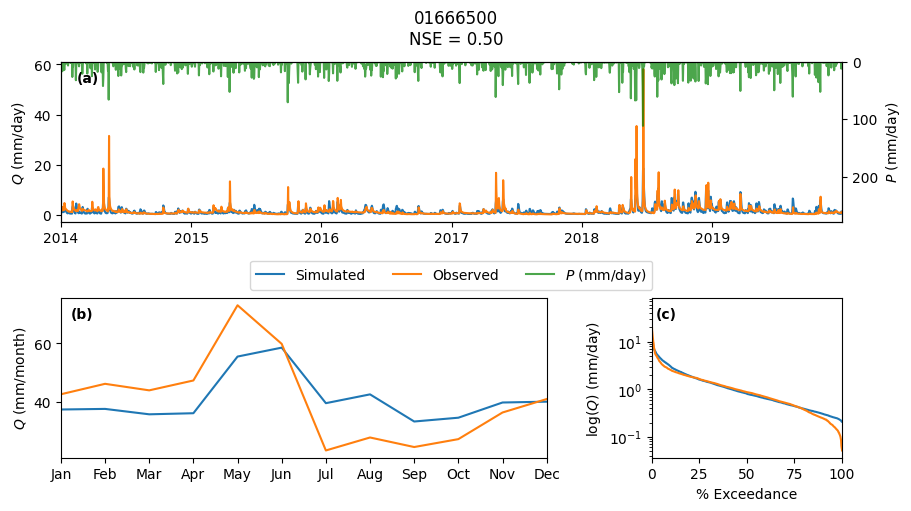

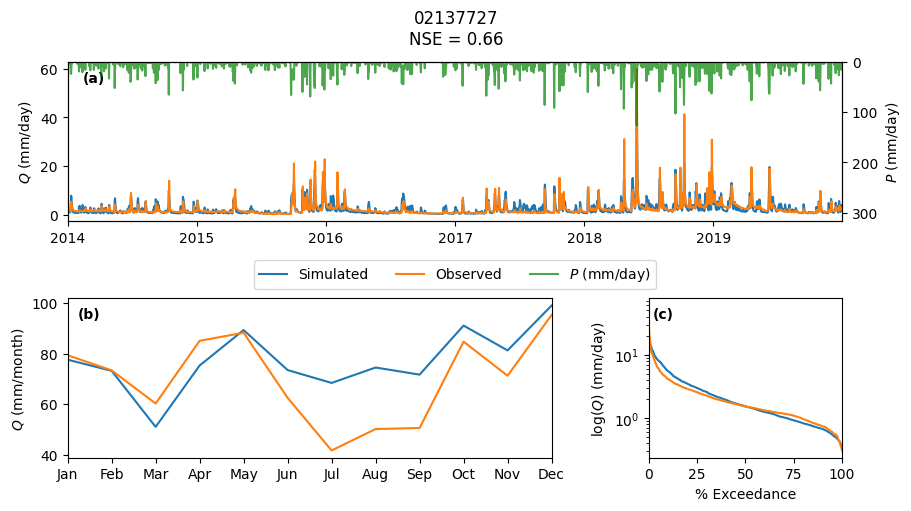

In [11]:
import pygeohydro as gh


for sid, clm_df in clm.items():
    model = HYMOD(clm_df, qobs[sid], c_max[sid], 0)
    qsim = model.simulate(best_params[sid].to_numpy("f4"))
    nse = compute_nse(qsim[cal_idx:], model.qobs[cal_idx:])
    discharge = pd.DataFrame(
        {"Simulated": qsim[cal_idx:], "Observed": model.qobs[cal_idx:]},
        index=qobs[sid].iloc[cal_idx:].index
    )
    _ = gh.plot.signatures(
        discharge,
        clm_df.iloc[cal_idx:].pr,
        title=f"{sid}\nNSE = {nse:.2f}",
    )

As the plots demonstrate, the model is able to capture the streamflow dynamics well for both watersheds with NSE values larger than 0.5.

## Final Remarks

This tutorial, demonstrated the application of HySetter for preparing data to run a hydrologic model. HySetter is a powerful tool that can facilitate the data preparation process for hydrologic modeling and move towards a more reproducible and transparent workflow. Users can easily modify the configuration file to obtain the required data for different watersheds and run the model.